In [774]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [775]:
DATASET_DIR = "Assignment 1 Input Images/Question 2 and 3 Images"
LEFT_IMAGE_RELATIVE_PATH = "000000.png"
RIGHT_IMAGE_RELATIVE_PATH = "000023.png"
METADATA_RELATIVE_PATH = "FM.txt"

In [776]:
left_image_path = os.path.join(DATASET_DIR, LEFT_IMAGE_RELATIVE_PATH)
right_image_path = os.path.join(DATASET_DIR, RIGHT_IMAGE_RELATIVE_PATH)
metadata_path = os.path.join(DATASET_DIR, METADATA_RELATIVE_PATH)

## handle metadata

In [777]:
metadata = None
with open(metadata_path) as metadata_file:
    metadata = metadata_file.readlines()

print(metadata)

['F=[3.34638533e-07,  7.58547151e-06, -2.04147752e-03;\n', '   -5.83765868e-06,  1.36498636e-06, 2.67566877e-04;\n', '   1.45892349e-03, -4.37648316e-03,  1.00000000e+00]\n']


In [778]:
matrix = "".join(metadata).split('[')[1].split(']')[0].split(';\n   ')

for i, row in enumerate(matrix):
    matrix[i] = [eval(x) for x in row.split(', ')]

F = np.array(matrix)
F

array([[ 3.34638533e-07,  7.58547151e-06, -2.04147752e-03],
       [-5.83765868e-06,  1.36498636e-06,  2.67566877e-04],
       [ 1.45892349e-03, -4.37648316e-03,  1.00000000e+00]])

## compute epipolar lines

In [779]:
LEFT_SAMPLE_PIXEL = np.array([
    [200], 
    [100]
])

RIGHT_SAMPLE_PIXEL = np.array([
    [700], 
    [200]
])

In [780]:
# ur.T @ F @ ul = 0
def compute_epipolar_line(fundamental_matrix, pixel, is_left_pixel):
    homogeneous_pixel = np.vstack((pixel, np.ones(1)))

    if is_left_pixel:
        return fundamental_matrix @ homogeneous_pixel
    else:
        return homogeneous_pixel.T @ fundamental_matrix

In [781]:
line_on_right_image = compute_epipolar_line(F, LEFT_SAMPLE_PIXEL, True)

In [782]:
line_on_left_image = compute_epipolar_line(F, RIGHT_SAMPLE_PIXEL, False)

In [783]:
def add_epipolar_line(image, epipolar_line, color):
    a, b, c = epipolar_line.flatten()

    x0 = 0
    y0 = int(-c / b)

    x1 = image.shape[1]
    y1 = int((-c - a * x1) / b)

    cv2.line(image, (x0, y0), (x1, y1), color, 2)

In [784]:
# draw points on image
def add_pixel(image, point, color):
    cv2.circle(image, (point.flatten()), 4, color, -1)

In [785]:
GREEN = (0, 255, 0)
RED = (255, 0, 0)

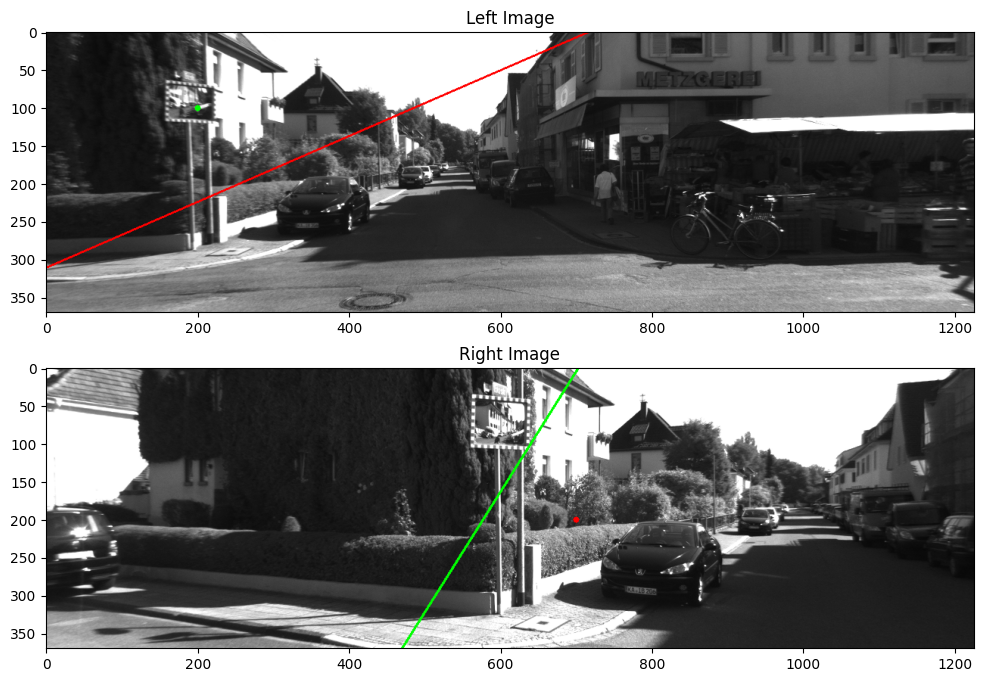

In [786]:
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

add_pixel(left_image, LEFT_SAMPLE_PIXEL, GREEN)
add_pixel(right_image, RIGHT_SAMPLE_PIXEL, RED)

add_epipolar_line(left_image, line_on_left_image, RED)
add_epipolar_line(right_image, line_on_right_image, GREEN)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].imshow(left_image)
ax[0].set_title("Left Image")
ax[1].imshow(right_image)
ax[1].set_title("Right Image")
plt.show()

## helper functions

In [787]:
def find_epipolar_line_boundaries(image, epipolar_line):
    a, b, c = epipolar_line.flatten()

    endpoints = []

    x0 = 0
    y0 = int(-c / b)
    if y0 >= 0 and y0 < image.shape[0]:
        endpoints.append([x0, y0])

    x1 = image.shape[1]
    y1 = int((-c - a * x1) / b)
    if y1 >= 0 and y1 < image.shape[0]:
        endpoints.append([x1, y1])

    y2 = 0
    x2 = int(-c / a)
    if x2 >= 0 and x2 < image.shape[1]:
        endpoints.append([x2, y2])

    y3 = image.shape[0]
    x3 = int((-c - b * y3) / a)
    if x3 >= 0 and x3 < image.shape[1]:
        endpoints.append([x3, y3])

    return endpoints

In [788]:
left_line_boundaries = find_epipolar_line_boundaries(left_image, line_on_left_image)
right_line_boundaries = find_epipolar_line_boundaries(right_image, line_on_right_image)

print(left_line_boundaries)
print(right_line_boundaries)

[[0, 311], [714, 0]]
[[702, 0], [470, 370]]


In [789]:
def find_all_points_on_line(line_boundaries, line):
    x0, y0 = line_boundaries[0]
    x1, y1 = line_boundaries[1]

    a, b, c = line.flatten()
    points = []

    for x in range(min(x0, x1), max(x0, x1)+1):
        y = int((-c - a * x) / b)
        points.append([x, y])
    
    return points

In [790]:
all_left_line_points = find_all_points_on_line(left_line_boundaries, line_on_left_image)
all_right_line_points = find_all_points_on_line(right_line_boundaries, line_on_right_image)
print(len(all_left_line_points), len(all_right_line_points))

715 233


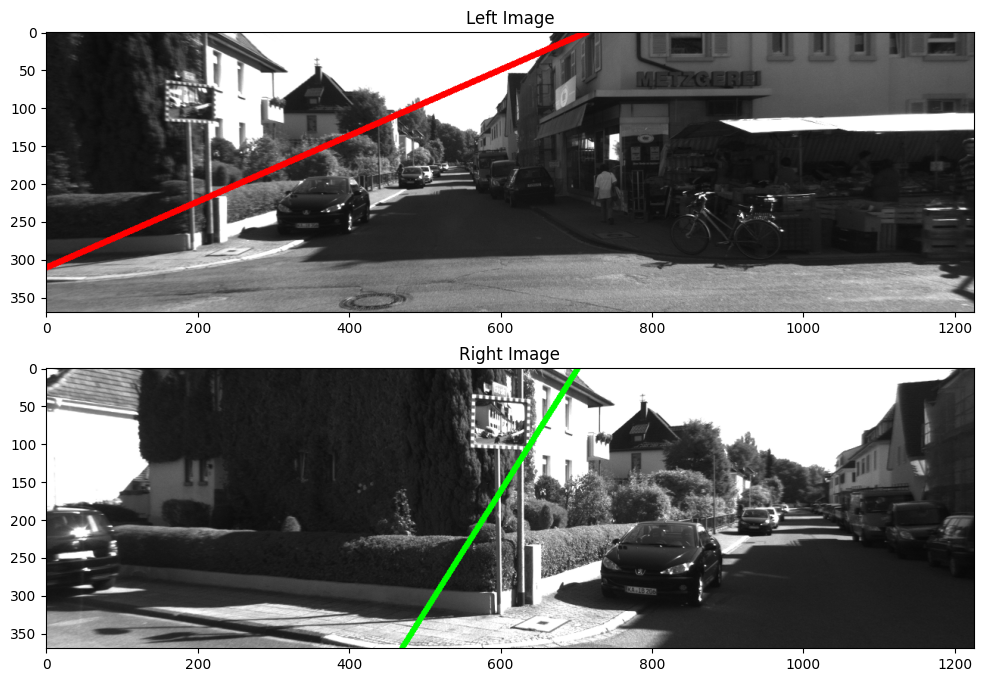

In [791]:
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

for point in all_left_line_points:
    add_pixel(left_image, np.array(point), RED)

for point in all_right_line_points:
    add_pixel(right_image, np.array(point), GREEN)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].imshow(left_image)
ax[0].set_title("Left Image")
ax[1].imshow(right_image)
ax[1].set_title("Right Image")
plt.show()

In [792]:
def filter_points_for_window_size(image, all_points_on_line, window_size):
    half_window = (window_size-1) // 2
    filtered_points = []

    for i, point in enumerate(all_points_on_line):
        x, y = point

        if x - half_window < 0 or x + half_window >= image.shape[1] \
            or y - half_window < 0 or y + half_window >= image.shape[0]:
            continue

        filtered_points.append(point)
    
    return filtered_points

In [793]:
WINDOW_SIZE = 100

filtered_left_line_points = filter_points_for_window_size(left_image, all_left_line_points, WINDOW_SIZE)
filtered_right_line_points = filter_points_for_window_size(right_image, all_right_line_points, WINDOW_SIZE)

print(len(filtered_left_line_points), len(filtered_right_line_points))

553 171


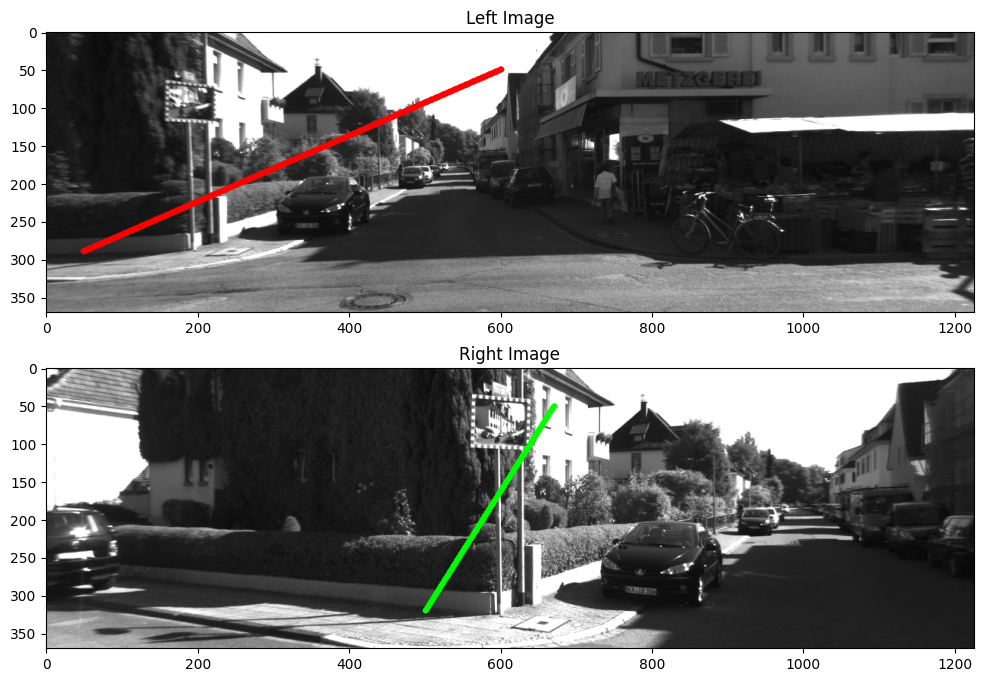

In [794]:
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

for point in filtered_left_line_points:
    add_pixel(left_image, np.array(point), RED)

for point in filtered_right_line_points:
    add_pixel(right_image, np.array(point), GREEN)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].imshow(left_image)
ax[0].set_title("Left Image")
ax[1].imshow(right_image)
ax[1].set_title("Right Image")
plt.show()

## 10 uniform points

In [795]:
def find_n_uniformly_distributed_points_on_line(all_points_on_line, n):
    uniformly_distributed_points = all_points_on_line[::len(all_points_on_line)//n][:n]
    return uniformly_distributed_points

In [796]:
NUM_POINTS = 10

left_line_uniform_points = find_n_uniformly_distributed_points_on_line(filtered_left_line_points, NUM_POINTS)
right_line_uniform_points = find_n_uniformly_distributed_points_on_line(filtered_right_line_points, NUM_POINTS)

print(len(left_line_uniform_points), len(right_line_uniform_points))

10 10


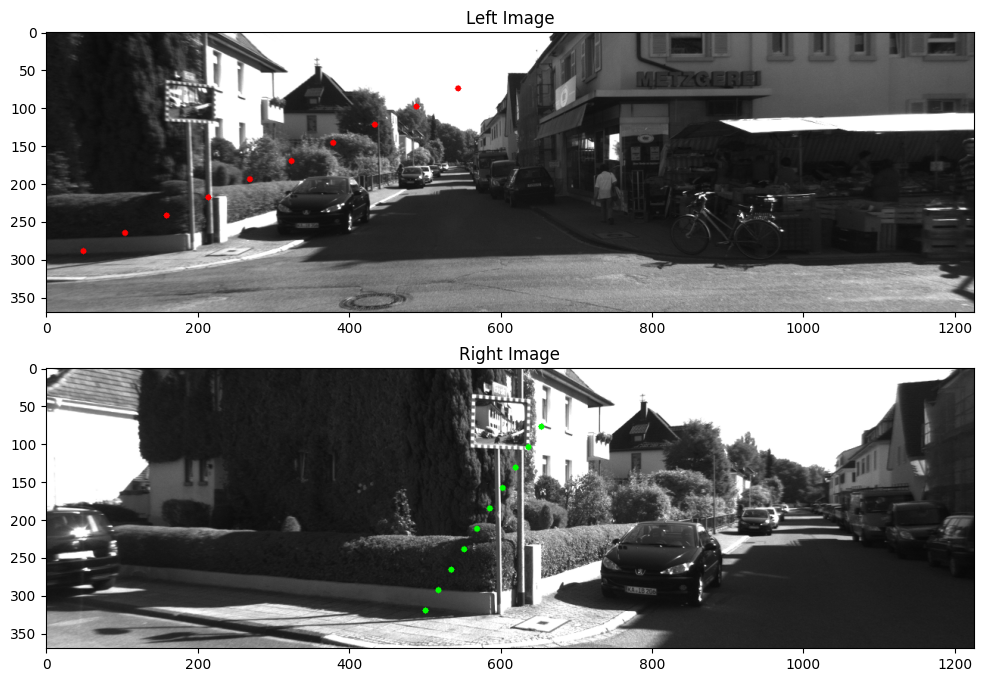

In [797]:
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

for point in left_line_uniform_points:
    add_pixel(left_image, np.array(point), RED)

for point in right_line_uniform_points:
    add_pixel(right_image, np.array(point), GREEN)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].imshow(left_image)
ax[0].set_title("Left Image")
ax[1].imshow(right_image)
ax[1].set_title("Right Image")
plt.show()

## correspondence search

In [798]:
def block_matching(left_image, right_image, point, window_size, F, is_left_point):
    x, y = point
    vector_point = np.array([[x], [y]])
    epipolar_line = compute_epipolar_line(F, vector_point, is_left_point)
    
    line_image = right_image if is_left_point else left_image
    epipolar_line_boundaries = find_epipolar_line_boundaries(line_image, epipolar_line)
    all_points_on_line = find_all_points_on_line(epipolar_line_boundaries, epipolar_line)
    filtered_points = filter_points_for_window_size(line_image, all_points_on_line, window_size)

    min_loss = np.inf
    best_match = None
    num_patch_neighbors = (window_size - 1) // 2
    point_image = left_image if is_left_point else right_image
    point_patch = point_image[y-num_patch_neighbors:y+num_patch_neighbors+1, x-num_patch_neighbors:x+num_patch_neighbors+1]

    for i in range(len(filtered_points)):
        x, y = all_points_on_line[i]
        # check if the patch is out of bounds
        if x < num_patch_neighbors or x >= line_image.shape[1] - num_patch_neighbors \
            or y < num_patch_neighbors or y >= line_image.shape[0] - num_patch_neighbors:
            continue

        patch = line_image[y-num_patch_neighbors:y+num_patch_neighbors+1, x-num_patch_neighbors:x+num_patch_neighbors+1]
        loss = np.sum(np.abs(patch - point_patch))
        if loss < min_loss:
            min_loss = loss
            best_match = [x, y]
    
    return best_match

In [799]:
left_point_best_matches = []
for i in range(len(left_line_uniform_points)):
    best_match = block_matching(left_image, right_image, left_line_uniform_points[i], WINDOW_SIZE, F, True)
    left_point_best_matches.append(best_match)

right_point_best_matches = []
for i in range(len(right_line_uniform_points)):
    best_match = block_matching(left_image, right_image, right_line_uniform_points[i], WINDOW_SIZE, F, False)
    right_point_best_matches.append(best_match)

print(len(left_point_best_matches), len(right_point_best_matches))
print(left_point_best_matches)
print(right_point_best_matches)

10 10
[[461, 309], [480, 287], [565, 262], [628, 233], [698, 200], [754, 174], [813, 147], [883, 115], [919, 98], [524, 281]]
[[181, 137], [74, 320], [85, 307], [77, 319], [77, 319], [77, 319], [197, 104], [76, 320], [129, 226], [141, 204]]


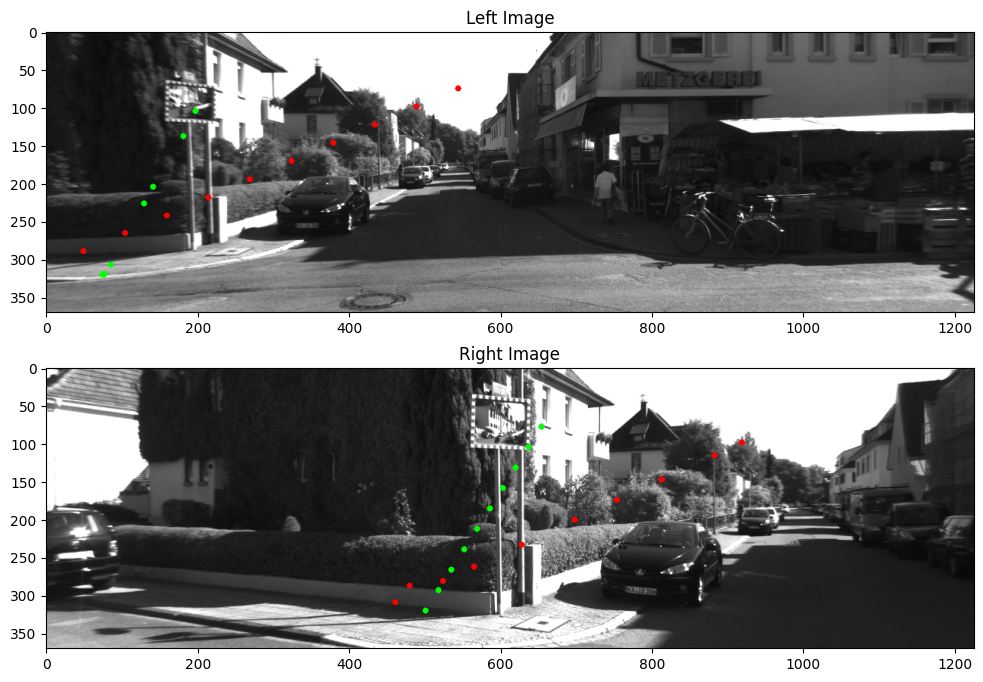

In [800]:
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

for point in left_line_uniform_points:
    add_pixel(left_image, np.array(point), RED)

for point in right_line_uniform_points:
    add_pixel(right_image, np.array(point), GREEN)

for point in left_point_best_matches:
    add_pixel(right_image, np.array(point), RED)

for point in right_point_best_matches:
    add_pixel(left_image, np.array(point), GREEN)


fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].imshow(left_image)
ax[0].set_title("Left Image")
ax[1].imshow(right_image)
ax[1].set_title("Right Image")
plt.show()